
# Forecast (new) Licenses Liquor Retail in Chicago

### Goals

Let's analyze the liquor retails from Chicago. It is important to set a few goals for this analysis:
- Analyze historical trends
- Engineer time-based features to capture temperal patterns.
- Evaluate the presence of seasonality or periodic behavior using cyclic encodings.
- Build scalable machine learning model in Apache Spark to forecast new/future license counts.

[Note] Although PySpark isn't built for classic ARIMA/ETS models, it supports scalable machine learning through MLlib, where you can still forecast using: Linear Regression on Time Features, Decision Tree / Random Forest Regressor, and Gradient Boosted Trees (GBT).

In [0]:
import math
from pyspark.sql import Row
from pyspark.sql.window import Window
from pyspark.sql.functions import percent_rank
from pyspark.sql.functions import col
from pyspark.sql.functions import month, year
from pyspark.sql.functions import lead
from pyspark.sql.functions import sin, cos, lit, count, lag, avg
from pyspark.sql.functions import stddev, max as spark_max, min as spark_min

## Load Data

Liquor dataset from 2025-05-29

In [0]:
data = spark.read.format("csv")\
  .option("inferSchema", True)\
  .option("header", True)\
  .load("/FileStore/tables/Liquor_Retail_20250529.csv")

data.display()

ID LICENSE ID ACCOUNT NUMBER SITE NUMBER LEGAL NAME DOING BUSINESS AS NAME ADDRESS CITY STATE ZIP CODE WARD PRECINCT WARD PRECINCT POLICE DISTRICT LICENSE CODE LICENSE DESCRIPTION BUSINESS ACTIVITY ID BUSINESS ACTIVITY LICENSE NUMBER APPLICATION TYPE APPLICATION CREATED DATE APPLICATION REQUIREMENTS COMPLETE PAYMENT DATE CONDITIONAL APPROVAL LICENSE TERM START DATE LICENSE TERM EXPIRATION DATE LICENSE APPROVED FOR ISSUANCE DATE ISSUED LICENSE STATUS LICENSE STATUS CHANGE DATE SSA LATITUDE LONGITUDE LOCATION 2483946-20190216 2640512 379857 4 PREMIER CATERING & EVENTS LLC PREMIER CATERING & EVENTS 500 W JACKSON BLVD 1ST CHICAGO IL 60661 34 12 34-12 1 1474 Package Goods 774 Retail Sales of Packaged Liquor 2483946 RENEW null 2018-12-15 2019-03-06 N 2019-02-16 2019-07-15 2019-03-06 2019-03-07 AAI null null 41.878153523 -87.639638623 POINT (-87.63963862300314 41.87815352261035) 2670919-20190724 2670919 360549 4 THE BEER TEMPLE LLC THE BEER TEMPLE 3169-3175 N ELSTON AVE CHICAGO IL 60618 35 19 35-19 14 1474 Package Goods 774 Retail Sales of Packaged Liquor 2670919 C_EXPA 2019-05-30 2019-06-12 2019-06-12 N 2019-07-24 2019-09-15 2019-07-24 2019-07-24 AAI null null 41.93877274 -87.697205524 POINT (-87.69720552355243 41.93877273984495) 1898745-20190816 2673995 301605 2 ETA WHOLESALE & RETAIL INC. DOLLAR PRICE PLUS 3041 N PULASKI RD 1 CHICAGO IL 60641 31 16 31-16 25 1474 Package Goods 774 Retail Sales of Packaged Liquor 1898745 RENEW null 2019-06-15 2019-08-16 N 2019-08-16 2019-11-15 2019-08-16 2019-08-16 AAI null null 41.936635931 -87.726968915 POINT (-87.72696891450994 41.93663593117463) 2555853-20191216 2704049 5273 52 ALDI INC. ALDI INC. #53 5501 S HARLEM AVE 1 CHICAGO IL 60638 23 1 23-1 8 1474 Package Goods 774 Retail Sales of Packaged Liquor 2555853 RENEW null 2019-12-04 2019-12-04 N 2019-12-16 2020-01-15 2019-12-04 2019-12-04 AAI null null 41.791852065 -87.801377799 POINT (-87.80137779892857 41.7918520654401) 2469767-20190716 2665761 15538 26 TARGET CORPORATION TARGET STORE T-3208 3204 N CLARK ST CHICAGO IL 60657 44 20 44-20 19 1474 Package Goods 774 Retail Sales of Packaged Liquor 2469767 RENEW null 2019-05-15 2019-06-20 N 2019-07-16 2020-02-15 2019-06-20 2019-06-21 AAI null 17 41.940087278 -87.650960931 POINT (-87.65096093052412 41.94008727755832) 2542069-20191016 2685203 15538 28 TARGET CORPORATION TARGET STORE T-3214 3300 N ASHLAND AVE CHICAGO IL 60657 32 47 32-47 19 1474 Package Goods 774 Retail Sales of Packaged Liquor 2542069 RENEW null 2019-08-15 2019-09-20 N 2019-10-16 2020-02-15 2019-09-20 2019-09-23 AAI null 27 41.941565858 -87.668860403 POINT (-87.6688604029088 41.94156585778224) 2493190-20191016 2687732 400511 2 UMLAUT BREWING LLC OFF COLOR BREWING 1460 N KINGSBURY ST CHICAGO IL 60642 27 46 27-46 18 1474 Package Goods 774 Retail Sales of Packaged Liquor 2493190 RENEW null 2019-08-15 2020-01-14 N 2019-10-16 2020-02-15 2020-01-14 2020-01-15 AAI null null 41.907542939 -87.651503777 POINT (-87.6515037774827 41.907542938729264) 2511560-20190416 2648189 16085 3 FOREGIVENESS, INC. MAPLE & ASH/ EIGHT BAR 6-8 W MAPLE ST CHICAGO IL 60610 2 60 2-60 18 1474 Package Goods 774 Retail Sales of Packaged Liquor 2511560 RENEW null 2019-02-22 2019-04-06 N 2019-04-16 2020-02-15 2019-04-06 2019-04-10 AAI null null 41.901990808 -87.628593803 POINT (-87.62859380325996 41.90199080838916) 2563650-20190606 2563650 422493 1 BODEGA DIVISION INC BODEGA DIVISION 2500 W DIVISION ST 1 CHICAGO IL 60622 26 20 26-20 14 1474 Package Goods 774 Retail Sales of Packaged Liquor 2563650 ISSUE 2017-10-19 2018-01-05 2017-12-14 N 2019-06-06 2020-03-15 2019-06-06 2019-06-06 AAI null null 41.903101936 -87.689551755 POINT (-87.68955175463354 41.90310193590674) 2560001-20191116 2690962 32101 1 MARSHALL FIELD'S CHICAGO, INC. MACY'S 111 N STATE ST CHICAGO IL 60602 34 9 34-9 1 1474 Package Goods 774 Retail Sales of Packaged Liquor 2560001 RENEW null 2019-09-15 2019-11-05 N 2019-11-16 2020-03-15 2019-11-05 2020-02-10 AAI null 1 41.883473122 -87.62772975 POINT (-87.627729


## Preprocessing

Checkin on the data and preprare the dataset for the forecasting problem.

In [0]:
# The feature APPLICATION TYPE informs if the license was issued, renewed, or changed (e.g. expand, location).
# Let's check the number of records for each type.

data.groupby("APPLICATION TYPE").count().display()

APPLICATION TYPE count ISSUE 264 C_EXPA 8 RENEW 2505


- We have a total of 264 initial license applications over the past years.
- RENEW applications are a significant portion of the records.

**[Note]** This dataset contains different license type such as RENEW and C_EXPA. However, in this notebook, I'm focusing on the initial license applications (i.e., new issued licenses - ISSUE application type).

In [0]:
# Select only ISSUE application type
issued = data.filter(col("APPLICATION TYPE") == "ISSUE")
issued.display()

ID LICENSE ID ACCOUNT NUMBER SITE NUMBER LEGAL NAME DOING BUSINESS AS NAME ADDRESS CITY STATE ZIP CODE WARD PRECINCT WARD PRECINCT POLICE DISTRICT LICENSE CODE LICENSE DESCRIPTION BUSINESS ACTIVITY ID BUSINESS ACTIVITY LICENSE NUMBER APPLICATION TYPE APPLICATION CREATED DATE APPLICATION REQUIREMENTS COMPLETE PAYMENT DATE CONDITIONAL APPROVAL LICENSE TERM START DATE LICENSE TERM EXPIRATION DATE LICENSE APPROVED FOR ISSUANCE DATE ISSUED LICENSE STATUS LICENSE STATUS CHANGE DATE SSA LATITUDE LONGITUDE LOCATION 2563650-20190606 2563650 422493 1 BODEGA DIVISION INC BODEGA DIVISION 2500 W DIVISION ST 1 CHICAGO IL 60622 26 20 26-20 14 1474 Package Goods 774 Retail Sales of Packaged Liquor 2563650 ISSUE 2017-10-19 2018-01-05 2017-12-14 N 2019-06-06 2020-03-15 2019-06-06 2019-06-06 AAI null null 41.903101936 -87.689551755 POINT (-87.68955175463354 41.90310193590674) 2600371-20200714 2600371 299710 98 HIGHLAND PARK CVS, L.L.C. CVS/PHARMACY #10942 310 S MICHIGAN AVE 1 CHICAGO IL 60604 34 33 34-33 1 1474 Package Goods 774 Retail Sales of Packaged Liquor 2600371 ISSUE 2018-05-15 2018-09-11 2018-08-31 Y 2020-07-14 2020-10-15 2018-10-12 2018-10-12 AAI null null 41.877987807 -87.624459801 POINT (-87.62445980070322 41.8779878069696) 2636305-20190114 2636305 431993 1 RBB FOODS, INC. LUCKY GROCERIES 4200 W ARMITAGE AVE 1 CHICAGO IL 60639 35 12 35-12 25 1474 Package Goods 774 Retail Sales of Packaged Liquor 2636305 ISSUE 2018-11-19 2018-12-19 2018-12-06 N 2019-01-14 2021-01-15 2019-01-14 2019-01-14 AAI null null 41.917212297 -87.731510919 POINT (-87.73151091917421 41.91721229711406) 2631272-20190116 2631272 410272 8 AMAZON RETAIL LLC AMAZON GO 111 E WACKER DR 1 CHICAGO IL 60601 42 40 42-40 1 1474 Package Goods 774 Retail Sales of Packaged Liquor 2631272 ISSUE 2018-10-24 2018-12-27 2018-11-19 Y 2019-01-16 2021-02-15 2019-01-16 2019-01-16 AAI null null 41.888079426 -87.62404737 POINT (-87.62404736976374 41.88807942610461) 2636681-20190508 2636681 431767 1 HARMONY PALACE INC. HARMONY PALACE 2402 S WENTWORTH AVE 1 CHICAGO IL 60616 11 6 11-6 9 1474 Package Goods 774 Retail Sales of Packaged Liquor 2636681 ISSUE 2018-11-29 2019-03-06 2019-02-27 N 2019-05-08 2021-05-15 2019-05-08 2019-05-08 AAI null null 41.849052379 -87.632076919 POINT (-87.63207691880118 41.84905237872757) 2647294-20190503 2647294 456413 1 GB LICENSE, LLC GOPUFF 1347 S ASHLAND AVE 1 CHICAGO IL 60608 28 5 28-5 12 1474 Package Goods 774 Retail Sales of Packaged Liquor 2647294 ISSUE 2019-02-11 2019-04-03 2019-03-05 Y 2019-05-03 2021-05-15 2019-05-03 2019-05-03 AAI null null 41.863691227 -87.666158506 POINT (-87.66615850597972 41.863691227493106) 2630763-20190509 2630763 432094 1 BEERSHOP 2 LLC DRINK SHOP 2513 W ARMITAGE AVE 1 CHICAGO IL 60647 1 29 1-29 14 1474 Package Goods 774 Retail Sales of Packaged Liquor 2630763 ISSUE 2018-10-16 2018-11-21 2018-12-20 Y 2019-05-09 2021-05-15 2019-05-09 2019-05-09 AAC 2020-07-09 null 41.917439166 -87.690474891 POINT (-87.69047489099341 41.917439165597116) 2617199-20190419 2617199 416387 1 SHRUMI INC. MILLENNIAL MART 848 N ORLEANS ST 1 CHICAGO IL 60610 2 48 2-48 18 1474 Package Goods 774 Retail Sales of Packaged Liquor 2617199 ISSUE 2018-08-08 2019-03-20 2019-03-14 N 2019-04-19 2021-05-15 2019-04-19 2019-04-19 AAI null null 41.89812004 -87.63737677 POINT (-87.63737677022044 41.89812004046833) 2637085-20190514 2637085 454856 1 KEVIN FOOD AND LIQUOR, LLC KEVIN FOOD & LIQUOR 2700 W 47TH ST 1 CHICAGO IL 60632 12 8 12-8 9 1474 Package Goods 774 Retail Sales of Packaged Liquor 2637085 ISSUE 2018-12-07 2019-03-11 2019-02-21 N 2019-05-14 2021-05-15 2019-05-14 2019-05-14 AAI null null 41.808429081 -87.691827623 POINT (-87.691827623245 41.808429081452026) 2653029-20190627 2653029 457045 1 MITAL & SHIRIN INC. 7 -ELEVEN #38183B 135 W MADISON ST 1 CHICAGO IL 60602 34 9 34-9 1 1474 Package Goods 774 Retail Sales of Packaged Liquor 2653029 ISSUE 2019-03-08 2019-04-29 2019-04-25 N 2019-06-27 2021-06-15 2019-06-27 2019-06-27 AAI null null 41.881856744 -87.631896162 POI


A few licenses were cancelled during its term (i.e. LICENSE STATUS equals AAC). However, there are still conunt as initial license applications. Therefore, I'm going to keep them because if a license is cancelled (AAC) or revoked (REV), this occurs after issuing it. The goal is to forecast the number of new applications here.

In [0]:
# Check if the have licenses with same LICENSE STATUS
# It was informed that a LICENSE NUMBER can have multiple records, 
# but it has different LICENSE STATUS. Therefore, I double check for duplicate LICENSE STATUS.

#issued.groupby(["LICENSE NUMBER", "LICENSE STATUS"]).count().display()
# Answer: no duplicate was found!


### Feature engineering

#### Create base set and fill-in missing records

In [0]:
# Engineering date-time based features: month and year
issued = issued.withColumn("month", month(col("DATE ISSUED")))
issued = issued.withColumn("year", year(col("DATE ISSUED")))

# Aggregate monthly (new) licenses
# I'm going to use this dataset to perform forecasting
ct_issued = issued.groupby("year","month").agg(
    count("LICENSE NUMBER").alias("count_licenses"),
)

# Add missing year-month cases: fillin with zeros
missing_months = [
    Row(
        year=2023,
        month=4,
        count_licenses=0
    ),
    Row(
        year=2025,
        month=3,
        count_licenses=0
    ),
]
missing_months_df = spark.createDataFrame(missing_months)
ct_issued = ct_issued.union(missing_months_df)

# Engineering features: lag-based and rolling averages features

# Seasonality: let's transform month (cyclical variable) into sine and cosine components.
# Thus, the model can capture the seasonality - it know month 12 (December) is close to 1 (January).
ct_issued = ct_issued.withColumn("month_sin", 
                           sin(2 * math.pi * col("month")/lit(12)) )
ct_issued = ct_issued.withColumn("month_cos", 
                           cos(2 * math.pi * col("month")/lit(12)) )
ct_issued = ct_issued.sort("year","month")

# Lags:
window_spec = Window.orderBy("year","month")
ct_issued = ct_issued.withColumn("lag_1", lag("count_licenses",1).over(window_spec))
ct_issued = ct_issued.withColumn("lag_2", lag("count_licenses",2).over(window_spec))
ct_issued = ct_issued.withColumn("lag_3", lag("count_licenses",3).over(window_spec))
ct_issued = ct_issued.withColumn("growth_ratio", col("lag_1") / col("lag_2"))

# Delta:
ct_issued = ct_issued.withColumn("delta_license", col("count_licenses") - col("lag_1"))

# Stats:
rolling_window = Window.orderBy("year","month").rowsBetween(-2,0)
ct_issued = ct_issued.withColumn("std_count_3", stddev("count_licenses").over(rolling_window))
ct_issued = ct_issued.withColumn("min_count_3", spark_min("count_licenses").over(rolling_window))
ct_issued = ct_issued.withColumn("avg_count_3", avg("count_licenses").over(rolling_window))
ct_issued = ct_issued.withColumn("max_count_3", spark_max("count_licenses").over(rolling_window))
ct_issued = ct_issued.withColumn("rolling_max_delta", col("max_count_3") / col("min_count_3"))
ct_issued = ct_issued.withColumn("trend_indicator", col("lag_1") - col("avg_count_3"))

ct_issued = ct_issued.withColumn("delta_ratio", col("delta_license") / col("avg_count_3"))
ct_issued = ct_issued.withColumn("trend_score", col("trend_indicator") * col("growth_ratio"))

# Shift target
window = Window.orderBy("year","month")
ct_issued = ct_issued.withColumn("target", lead("count_licenses", 1).over(window))

# Fillna
ct_issued = ct_issued.fillna(0, subset=["growth_ratio", "rolling_max_delta", "trend_score"])

# Drop missing records
ct_issued = ct_issued.dropna(subset=["target", "lag_1", "lag_2", "lag_3", "avg_count_3"])

ct_issued.display()

year month count_licenses month_sin month_cos lag_1 lag_2 lag_3 growth_ratio delta_license std_count_3 min_count_3 avg_count_3 max_count_3 rolling_max_delta trend_indicator delta_ratio trend_score target 2019 3 4 1.0 6.123233995736766E-17 2 5 1 0.4 2 1.5275252316519468 2 3.6666666666666665 5 2.5 -1.6666666666666665 0.5454545454545455 -0.6666666666666666 5 2019 4 5 0.8660254037844387 -0.4999999999999998 4 2 5 2.0 1 1.5275252316519468 2 3.6666666666666665 5 2.5 0.3333333333333335 0.27272727272727276 0.666666666666667 7 2019 5 7 0.49999999999999994 -0.8660254037844387 5 4 2 1.25 2 1.5275252316519465 4 5.333333333333333 7 1.75 -0.33333333333333304 0.375 -0.4166666666666663 8 2019 6 8 1.2246467991473532E-16 -1.0 7 5 4 1.4 1 1.5275252316519468 5 6.666666666666667 8 1.6 0.33333333333333304 0.15 0.46666666666666623 6 2019 7 6 -0.4999999999999997 -0.8660254037844388 8 7 5 1.1428571428571428 -2 1.0 6 7.0 8 1.3333333333333333 1.0 -0.2857142857142857 1.1428571428571428 2 2019 8 2 -0.8660254037844385 -0.5000000000000004 6 8 7 0.75 -4 3.055050463303893 2 5.333333333333333 8 4.0 0.666666666666667 -0.75 0.5000000000000002 5 2019 9 5 -1.0 -1.8369701987210297E-16 2 6 8 0.3333333333333333 3 2.0816659994661326 2 4.333333333333333 6 3.0 -2.333333333333333 0.6923076923076924 -0.7777777777777777 3 2019 10 3 -0.8660254037844386 0.5000000000000001 5 2 6 2.5 -2 1.5275252316519468 2 3.3333333333333335 5 2.5 1.6666666666666665 -0.6 4.166666666666666 4 2019 11 4 -0.5000000000000004 0.8660254037844384 3 5 2 0.6 1 1.0 3 4.0 5 1.6666666666666667 -1.0 0.25 -0.6 8 2019 12 8 -2.4492935982947064E-16 1.0 4 3 5 1.3333333333333333 4 2.6457513110645907 3 5.0 8 2.6666666666666665 -1.0 0.8 -1.3333333333333333 3 2020 1 3 0.49999999999999994 0.8660254037844387 8 4 3 2.0 -5 2.6457513110645907 3 5.0 8 2.6666666666666665 3.0 -1.0 6.0 10 2020 2 10 0.8660254037844386 0.5000000000000001 3 8 4 0.375 7 3.605551275463989 3 7.0 10 3.3333333333333335 -4.0 1.0 -1.5 3 2020 3 3 1.0 6.123233995736766E-17 10 3 8 3.3333333333333335 -7 4.041451884327381 3 5.333333333333333 10 3.3333333333333335 4.666666666666667 -1.3125 15.555555555555557 5 2020 4 5 0.8660254037844387 -0.4999999999999998 3 10 3 0.3 2 3.605551275463989 3 6.0 10 3.3333333333333335 -3.0 0.3333333333333333 -0.8999999999999999 3 2020 5 3 0.49999999999999994 -0.8660254037844387 5 3 10 1.6666666666666667 -2 1.1547005383792517 3 3.6666666666666665 5 1.6666666666666667 1.3333333333333335 -0.5454545454545455 2.2222222222222228 1 2020 6 1 1.2246467991473532E-16 -1.0 3 5 3 0.6 -2 2.0 1 3.0 5 5.0 0.0 -0.6666666666666666 0.0 3 2020 7 3 -0.4999999999999997 -0.8660254037844388 1 3 5 0.3333333333333333 2 1.1547005383792517 1 2.3333333333333335 3 3.0 -1.3333333333333335 0.8571428571428571 -0.4444444444444445 7 2020 8 7 -0.8660254037844385 -0.5000000000000004 3 1 3 3.0 4 3.055050463303893 1 3.6666666666666665 7 7.0 -0.6666666666666665 1.090909090909091 -1.9999999999999996 2 2020 9 2 -1.0 -1.8369701987210297E-16 7 3 1 2.3333333333333335 -5 2.6457513110645907 2 4.0 7 3.5 3.0 -1.25 7.0 7 2020 10 7 -0.8660254037844386 0.5000000000000001 2 7 3 0.2857142857142857 5 2.8867513459481287 2 5.333333333333333 7 3.5 -3.333333333333333 0.9375 -0.9523809523809522 2 2020 11 2 -0.5000000000000004 0.8660254037844384 7 2 7 3.5 -5 2.8867513459481287 2 3.6666666666666665 7 3.5 3.3333333333333335 -1.3636363636363638 11.666666666666668 1 2020 12 1 -2.4492935982947064E-16 1.0 2 7 2 0.2857142857142857 -1 3.214550253664318 1 3.3333333333333335 7 7.0 -1.3333333333333335 -0.3 -0.380952380952381 4 2021 1 4 0.49999999999999994 0.8660254037844387 1 2 7 0.5 3 1.5275252316519465 1 2.3333333333333335 4 4.0 -1.3333333333333335 1.2857142857142856 -0.6666666666666667 1 2021 2 1 0.8660254037844386 0.5000000000000001 4 1 2 4.0 -3 1.7320508075688772 1 2.0 4 4.0 2.0 -1.5 8.0 1 2021 3 1 1.0 6.123233995736766E-17 1 4 1 0.25 0 1.7320508075688772 1 2.0 4 4.0 -1.0 0.0 -0.25 7 2021 4 7 0.8660254037844387 -0.4999999999999998 1 1 4 1.0 6 3.4641016151377544 1 3.0 7 7.0 -2.0 2.0 -2.0 2 202

In [0]:
# Check on correlation between features and target
features = ["month_sin", "month_cos", "lag_1", "lag_2", "lag_3", "growth_ratio", "delta_license", 
            "std_count_3", "min_count_3", "avg_count_3", "max_count_3", "rolling_max_delta", "trend_indicator", 
            "delta_ratio", "trend_score"]

for feature in features:
    corr_value = ct_issued.stat.corr("target", feature)
    print(f"{feature} x target corr: {corr_value:.4f}")

month_sin x target corr: -0.0641
month_cos x target corr: -0.1153
lag_1 x target corr: 0.2576
lag_2 x target corr: 0.0545
lag_3 x target corr: -0.0446
growth_ratio x target corr: 0.1040
delta_license x target corr: -0.1922
std_count_3 x target corr: 0.1053
min_count_3 x target corr: 0.1498
avg_count_3 x target corr: 0.1606
max_count_3 x target corr: 0.1857
rolling_max_delta x target corr: 0.0645
trend_indicator x target corr: 0.1843
delta_ratio x target corr: -0.1227
trend_score x target corr: 0.2119


- Features like **lag_1**, **delta_ratio**, **max_count_3**, **trend_indicator**, and **trend_score** show moderate predictive power.
- Most other features are statistically weak (|corr| < 0.15).

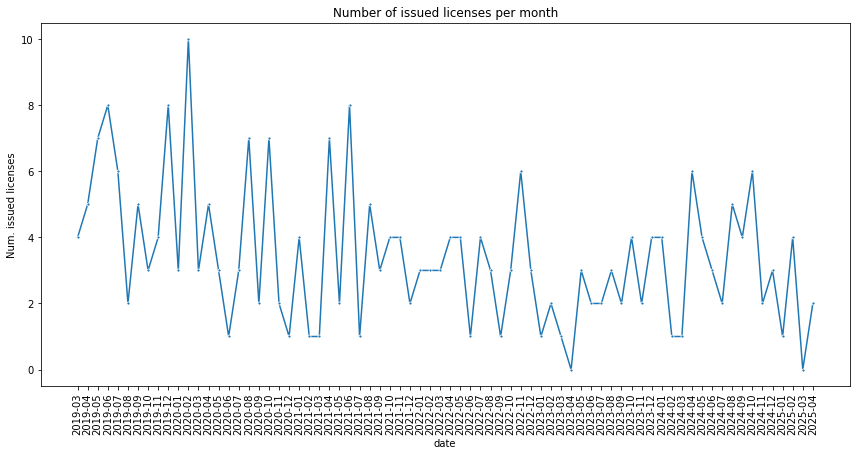

In [0]:
#. PySpark is not meant to plot directly, but distributed processing. 
# Also, it doesn't support visualization natively. Therefore, I convert the PySpark DF
# to Pandas DF. However, use .toPandas() is not recommended on hugh PySpark DFs.
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,6))
markers = ['.','o','d','*','s','^','v','2']
df_pandas = ct_issued.toPandas()
df_pandas["date"] = df_pandas["year"].astype(str) +"-"+ df_pandas["month"].astype(str).str.zfill(2)

sns.lineplot(data=df_pandas, x="date", y="count_licenses", marker=".")
plt.title("Number of issued licenses per month")
plt.ylabel("Num. issued licenses")
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

[Notes] 
- I don't really see any clear pattern ove the past years. However...
  - In 2019, we see an increasing trend from February to June (Winter to Spring). This means many liquor retail licenses were issued during that period.
  - The largest number of issued licenses occurred in February 2020. This happened right before Corona hit the US - administration declared a national emergency on March 13 and the first wave of infections peaked in April 2020. This might be one of the major influences for the downward trend around that period.
- We don't have much data. Forecasting (new) issue licenses might not have good results, but let's give it a chance.

In [0]:
# Remove weak features
ct_issued = ct_issued.drop("month_sin", "month_cos", "lag_2", "lag_3", "growth_ratio", "std_count_3")

#### Split dataset - Training and Test sets

In [0]:
# Splitting the dataset into training and test sets

# Create percentage of data
part_order = Window.partitionBy().orderBy("year","month")
ct_issued = ct_issued.withColumn("rank", percent_rank().over(part_order))

X_train = ct_issued.where("rank <= 0.8").drop("rank")
X_test = ct_issued.where("rank > 0.8").drop("rank")


## Build Model

Let's build a model to forecast new licenses.

In [0]:
from pyspark.sql.functions import round
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

In [0]:
# Linear Regression is going to be our baseline model

# Features for LR
lr_feature_cols = ["lag_1", "delta_license", "min_count_3", "avg_count_3",
                    "max_count_3", "trend_indicator", "delta_ratio", "trend_score"]
assembler_lr = VectorAssembler(inputCols=lr_feature_cols, outputCol="features_lr")

# Baseline model: Linear Regression
lr = LinearRegression(featuresCol="features_lr", labelCol="target", 
                      regParam=0.7, elasticNetParam=0.5
                      )

# Pipeline
lr_pipeline = Pipeline(stages=[assembler_lr, lr])
lr_model = lr_pipeline.fit(X_train)

# Predict
lr_predictions = lr_model.transform(X_test)

# Evaluation
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="target")
rmse = evaluator.evaluate(lr_predictions, {evaluator.metricName:"rmse"})
r2 = evaluator.evaluate(lr_predictions, {evaluator.metricName:"r2"})
print(f"RMSE: {rmse}")
print(f"R2: {r2}")

RMSE: 1.7843809283315253
R2: -0.06291311856600479


In [0]:
# Select features:
lr_predictions.select("year","month","count_licenses", "lag_1", "lag_2", "avg_count_3", "target", "prediction").display()

# Show all features:
#lr_predictions.display()

year month count_licenses lag_1 lag_2 avg_count_3 target prediction 2024 2 1 4 4 3.0 1 3.4915254237288136 2024 3 1 1 4 2.0 6 3.4915254237288136 2024 4 6 1 1 2.6666666666666665 4 3.4915254237288136 2024 5 4 6 1 3.6666666666666665 3 3.4915254237288136 2024 6 3 4 6 4.333333333333333 2 3.4915254237288136 2024 7 2 3 4 3.0 5 3.4915254237288136 2024 8 5 2 3 3.3333333333333335 4 3.4915254237288136 2024 9 4 5 2 3.6666666666666665 6 3.4915254237288136 2024 10 6 4 5 5.0 2 3.4915254237288136 2024 11 2 6 4 4.0 3 3.4915254237288136 2024 12 3 2 6 3.6666666666666665 1 3.4915254237288136 2025 1 1 3 2 2.0 4 3.4915254237288136 2025 2 4 1 3 2.6666666666666665 0 3.4915254237288136 2025 3 0 4 1 1.6666666666666667 2 3.4915254237288136 2025 4 2 0 4 2.0 3 3.4915254237288136


### Boosted Trees

Use Gradient Boosted Trees (GBT)

In [0]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.pipeline import Pipeline

# Features for GBT
gbt_feature_cols = ["lag_1", "delta_license", "min_count_3", "avg_count_3",
                    "max_count_3", "trend_indicator", "delta_ratio", "trend_score"]
assembler_gbt = VectorAssembler(inputCols=gbt_feature_cols, outputCol="features_gbt")

# Model
# I tried different hypermeters for:
# - maxDepth: 2 to 15
# - stepSize: 0.01 to 1.0
# - maxIter: 20 to 100
# - subsamplingRate: 0.5 to 1.0
gbt = GBTRegressor(featuresCol="features_gbt", labelCol="target", 
                   maxDepth=5, stepSize=0.1, maxIter=50, 
                   subsamplingRate=0.8
                   )

# Pipeline
gbt_pipeline = Pipeline(stages=[assembler_gbt, gbt])
gbt_model = gbt_pipeline.fit(X_train)

# Predictions
gbt_predictions = gbt_model.transform(X_test)

# Evaluation
evaluator_gbt = RegressionEvaluator(predictionCol="prediction", labelCol="target")
rmse = evaluator_gbt.evaluate(gbt_predictions, {evaluator_gbt.metricName:"rmse"})
r2 = evaluator_gbt.evaluate(gbt_predictions, {evaluator_gbt.metricName:"r2"})
print(f"RMSE: {rmse}")
print(f"R2: {r2}")

RMSE: 2.0390302544202465
R2: -0.38793766342618197


In [0]:
# Select features:
gbt_predictions.select("year","month","count_licenses", "lag_1", "lag_2", "avg_count_3", "target", "prediction").display()

# Show all features:
#gbt_predictions.display()

year month count_licenses lag_1 lag_2 avg_count_3 target prediction 2024 2 1 4 4 3.0 1 3.2660364779962157 2024 3 1 1 4 2.0 6 6.966339521435933 2024 4 6 1 1 2.6666666666666665 4 2.0410578688082173 2024 5 4 6 1 3.6666666666666665 3 3.8589194384419843 2024 6 3 4 6 4.333333333333333 2 5.33618676560129 2024 7 2 3 4 3.0 5 2.8435808793828046 2024 8 5 2 3 3.3333333333333335 4 2.9840088281395394 2024 9 4 5 2 3.6666666666666665 6 3.7600222180970637 2024 10 6 4 5 5.0 2 3.6953287511194635 2024 11 2 6 4 4.0 3 7.653061275449172 2024 12 3 2 6 3.6666666666666665 1 6.000872330339114 2025 1 1 3 2 2.0 4 0.26038939531816396 2025 2 4 1 3 2.6666666666666665 0 2.3874873656306437 2025 3 0 4 1 1.6666666666666667 2 0.5203855642017623 2025 4 2 0 4 2.0 3 6.994117383207003


### Random Forest

Use Random Forest Regressor

In [0]:
from pyspark.ml.regression import RandomForestRegressor

rf_features = ["lag_1", "delta_license", "min_count_3", "avg_count_3",
                "max_count_3", "trend_indicator", "delta_ratio", "trend_score"]
assembler_rf = VectorAssembler(inputCols=rf_features, outputCol="features_rf")

rf = RandomForestRegressor(featuresCol="features_rf", labelCol="target")
rf_pipeline = Pipeline(stages=[assembler_rf, rf])
rf_model =  rf_pipeline.fit(X_train)

rf_predictions = rf_model.transform(X_test)

evaluator_rf = RegressionEvaluator(predictionCol="prediction", labelCol="target")
rmse = evaluator_rf.evaluate(rf_predictions, {evaluator_rf.metricName:"rmse"})
r2 = evaluator_rf.evaluate(rf_predictions, {evaluator_rf.metricName:"r2"})
print(f"RMSE: {rmse}")
print(f"R2: {r2}")

RMSE: 2.0920665459829983
R2: -0.4610787053186607



### Blending models - Ensemble!

Since boths models have weak predicting power. Let's blend them and see if we have any improvement.

Use models:
- LR
- GBT

In [0]:
# Merging predictions
lr_preds = lr_predictions.select("year","month", "target","prediction").withColumnRenamed("prediction", "prediction_lr")
gbt_preds = gbt_predictions.select("year","month","prediction").withColumnRenamed("prediction", "prediction_gbt")
blend_preds = lr_preds.join(gbt_preds, on=["year","month"])

In [0]:
from pyspark.sql.functions import expr

# Blend predictions
blend_preds = blend_preds.withColumn("prediction_blend", expr("0.7 * prediction_lr + 0.3 * prediction_gbt"))
# [Note] I test different weights, but I'm still getting poor results.

# Evaluate
evaluator_blend = RegressionEvaluator(predictionCol="prediction_blend", labelCol="target")

rmse = evaluator_blend.evaluate(blend_preds, {evaluator_blend.metricName:"rmse"})
r2 = evaluator_blend.evaluate(blend_preds, {evaluator_blend.metricName:"r2"})
print(f"RMSE: {rmse}")
print(f"R2: {r2}")

RMSE: 1.8896949060806738
R2: -0.19208165959218193



### Conclusion


In this notebook, I explored forecasting monthly liquor license issuance in Chicago using historical data. After feature engineering and model tuning, I found that liquor license issuance behaves erratically and isn’t explainable by internal signals alone — a strong sign that city policy or economic conditions are the true drivers. I compared the performance of three models — Linear Regression, Gradient Boosted Trees (GBT), and Random Forest (RF) — and evaluated them using RMSE and R².

The process included:
- Cleaning and aggregating over the last 6 years of license issuance records.
- Engineering time-based features such as lags, rolling stats, and cyclical encodings.
- Training and evaluting several machine learning models listed above.

Despite careful feature engineering and model selection, none of the models significantly outperformed a naive baseline, and all outputed low or even negative R² scores. Therefore, external drivers such as economic conditions, local policies, or event-driven factors might play a dominant role in license issuance but are not present in the dataset. Also internal time series feature were not sufficient to predict future behavior. Thus, a forecasting license issuance based on historical license data alone may not be feasible.


___